In [1]:
import numpy as np
import pandas
import urllib2
from sklearn.metrics.cluster import adjusted_rand_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from functools import reduce

In [2]:
chrs_length = [249250621,243199373,198022430,191154276,180915260,171115067,159138663,146364022,141213431,135534747,135006516,133851895,115169878,107349540,102531392,90354753,81195210,78077248,59128983,63025520,48129895,51304566]
res = 10000
bedf = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/data/E116-Ctcf.fc.signal.bigwig.10kb.bed'),sep='\t',header=None)
tabf = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/data/E116-Ctcf.fc.signal.bigwig.10kb.tab'),sep='\t',header=None)

In [3]:
###Define a function to caculate the ChIP-seq signal in each bin of corresponding Hi-C matrix######
def computeMatrix(bedfile,boundarylist,chrn,winsize,res,chrs_l,tabfile):
    blist = boundarylist[(boundarylist>winsize)&(boundarylist<(chrs_l-winsize*res)/res)].astype(int)
    mm = np.zeros((len(blist),2*winsize+1))
    chrinfo = tabfile.loc[bedfile[0]==chrn]
    for i in range(0,len(blist)):
        mm[i,:]=chrinfo.iloc[blist[i]-winsize:blist[i]+winsize+1,4].values
    return mm

In [4]:
def compute_jaccard_index(set_1, set_2, offset):
    if offset == 0:
        n = len(np.intersect1d(set_1,set_2))
    else:
        set_1_offset=np.copy(set_1)
        for i in range(0,offset):
            set_1_offset = np.union1d(np.union1d(set_1_offset,set_1_offset - 1),set_1_offset + 1)
        n = len(np.intersect1d(set_1_offset,set_2))
    return n / float(len(np.union1d(set_1,set_2)))

In [5]:
def compute_intersect(set_1, set_2, offset):
    nlist = np.zeros(offset+4)
    for i in range(0,offset+1):
        set_1_offset=np.copy(set_1)
        set_1_offset = np.union1d(set_1_offset - i,set_1_offset + i)
        nlist[i] = len(np.intersect1d(set_1_offset,set_2))
    nlist[i+1] = len(set_1)
    nlist[i+2] = len(set_2)
    nlist[i+3] = len(np.union1d(set_1,set_2))
    return nlist

In [6]:
def TADtoCluster (tads, chrbinlen, maxdist):
    tmat = np.zeros((chrbinlen,chrbinlen))
    ftads = tads[(tads[:,1]-tads[:,0]).argsort()[::-1],:].astype(int)
    a = []
    for i in range(0,ftads.shape[0]):
        tmat[ftads[i,0]:ftads[i,1],ftads[i,0]:ftads[i,1]] = i
    for offset in range(0,min(maxdist,chrbinlen-1)):
        ta= [row[rown+offset] for rown,row in enumerate(tmat) if rown+offset < len(row)]
        a+=ta
    return np.asarray(a)

In [7]:
def boundarylevel(tad):
    leftb,leftl = np.unique(tad[:,0],return_counts=True)
    rightb, rightl = np.unique(tad[:,1],return_counts=True)
    allb = np.copy(leftb)
    alll = np.copy(leftl)
    for i in range(0,len(rightb)):
        ind = np.where(leftb==rightb[i])[0]
        if len(ind) > 0:
            if rightl[i]>leftl[ind[0]]:
                alll[ind[0]]=rightl[i]
        else:
            allb=np.append(allb,rightb[i])
            alll=np.append(alll,rightl[i])
    return (allb,alll)

In [14]:
jar0 = []
jar1 = []
jar2 = []
jarrep = []
rand = []
randrep = []
Arrow_jar = []
Arrow_rand = []
repint = np.zeros(6)
rnint = np.zeros(6)
cOnTAD_rawball = np.empty((0,21))
cOnTAD_normball = np.empty((0,21))

l1b = np.array([0,0,0])
l2b = np.array([0,0,0])
l3b = np.array([0,0,0])
l4b = np.array([0,0,0])
l5b = np.array([0,0,0])
for chrnum in range(1,23):
    OnTAD_raw = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878/10kb/OnTAD_raw_pen0.1_max200_hsz5_chr'+str(chrnum)+'.tad'),sep='\t',header=None)
    OnTAD_rawa = OnTAD_raw.loc[(OnTAD_raw[2]>0),:].values[:,0:2]-1
    OnTAD_rawb = np.unique(OnTAD_rawa.flatten())
    #rawt = TADtoCluster(OnTAD_rawa, chrs_length[chrnum-1]/res, 200)
    OnTAD_norm = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878/10kb/OnTAD_KRnorm_pen0.1_max200_hsz5_chr'+str(chrnum)+'.tad'),sep='\t',header=None)
    OnTAD_norma = OnTAD_norm.loc[(OnTAD_norm[2]>0),:].values[:,0:2]-1
    OnTAD_normb = np.unique(OnTAD_norma.flatten())  
    #normt = TADtoCluster(OnTAD_norma, chrs_length[chrnum-1]/res, 200)
    OnTAD_rawallb, OnTAD_rawalll = boundarylevel(OnTAD_rawa)
    OnTAD_rawo1b = OnTAD_rawallb[OnTAD_rawalll==1]
    OnTAD_rawo2b = OnTAD_rawallb[OnTAD_rawalll==2]
    OnTAD_rawo3b = OnTAD_rawallb[OnTAD_rawalll==3]
    OnTAD_rawo4b = OnTAD_rawallb[OnTAD_rawalll==4]
    OnTAD_rawo5b = OnTAD_rawallb[OnTAD_rawalll>=5]
    l1b += np.array([len(OnTAD_rawo1b), len(np.intersect1d(OnTAD_rawo1b, OnTAD_normb)), len(np.intersect1d(reduce(np.union1d, (OnTAD_rawo1b, OnTAD_rawo1b-1, OnTAD_rawo1b+1 )), OnTAD_normb))])
    l2b += np.array([len(OnTAD_rawo2b), len(np.intersect1d(OnTAD_rawo2b, OnTAD_normb)), len(np.intersect1d(reduce(np.union1d, (OnTAD_rawo2b, OnTAD_rawo2b-1, OnTAD_rawo2b+1 )), OnTAD_normb))])
    l3b += np.array([len(OnTAD_rawo3b), len(np.intersect1d(OnTAD_rawo3b, OnTAD_normb)), len(np.intersect1d(reduce(np.union1d, (OnTAD_rawo3b, OnTAD_rawo3b-1, OnTAD_rawo3b+1 )), OnTAD_normb))])
    l4b += np.array([len(OnTAD_rawo4b), len(np.intersect1d(OnTAD_rawo4b, OnTAD_normb)), len(np.intersect1d(reduce(np.union1d, (OnTAD_rawo4b, OnTAD_rawo4b-1, OnTAD_rawo4b+1 )), OnTAD_normb))])
    l5b += np.array([len(OnTAD_rawo5b), len(np.intersect1d(OnTAD_rawo5b, OnTAD_normb)), len(np.intersect1d(reduce(np.union1d, (OnTAD_rawo5b, OnTAD_rawo5b-1, OnTAD_rawo5b+1 )), OnTAD_normb))])
    cOnTAD_rawball = np.append(cOnTAD_rawball,computeMatrix(bedf,OnTAD_rawb,'chr'+str(chrnum),10,10000,chrs_length[chrnum-1],tabf), axis=0)
    cOnTAD_normball = np.append(cOnTAD_normball,computeMatrix(bedf,OnTAD_normb,'chr'+str(chrnum),10,10000,chrs_length[chrnum-1],tabf), axis=0)
    print '####Done with chr'+str(chrnum)+'####'
'''
    OnTAD_rawrep1 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878_primary/10kb/OnTADtopdom_pen0.1_max200_chr'+str(chrnum)+'.tad'),sep='\t',header=None)
    OnTAD_rawrep1a = OnTAD_rawrep1.loc[(OnTAD_rawrep1[2]>0),:].values[:,0:2]-1
    OnTAD_rawrep1b = np.unique(OnTAD_rawrep1a.flatten())
    rep1t = TADtoCluster(OnTAD_rawrep1a, chrs_length[chrnum-1]/res, 200)
    OnTAD_rawrep2 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878_replicate/10kb/OnTADtopdom_pen0.1_max200_chr'+str(chrnum)+'.tad'),sep='\t',header=None)
    OnTAD_rawrep2a = OnTAD_rawrep2.loc[(OnTAD_rawrep2[2]>0),:].values[:,0:2]-1
    OnTAD_rawrep2b = np.unique(OnTAD_rawrep2a.flatten())
    rep2t = TADtoCluster(OnTAD_rawrep2a, chrs_length[chrnum-1]/res, 200)
    Arrowheadraw = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/juicer/Arrowhead.Gm12878.combined.10kb.m2000.raw.chr'+str(chrnum)),sep='\t',header=None)
    Arrowraw = Arrowheadraw.loc[:,1:2].values/res
    Arrowrawb=np.unique(Arrowraw.flatten())
    Arrowrawt = TADtoCluster(Arrowraw, chrs_length[chrnum-1]/res, 200)
    Arrowheadnorm = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/juicer/Arrowhead.Gm12878.10kb.KR.chr'+str(chrnum)),sep='\t',header=None)
    Arrownorm = Arrowheadnorm.loc[:,1:2].values/res
    Arrownormb=np.unique(Arrownorm.flatten())
    Arrownormt = TADtoCluster(Arrownorm, chrs_length[chrnum-1]/res, 200)
    Arrow_jar.append(compute_jaccard_index(Arrowrawb,Arrownormb,0))
    Arrow_rand.append(adjusted_rand_score(Arrowrawt, Arrownormt))
    jar0.append(compute_jaccard_index(OnTAD_rawb,OnTAD_normb,0))
    jar1.append(compute_jaccard_index(OnTAD_rawb,OnTAD_normb,1))
    jar2.append(compute_jaccard_index(OnTAD_rawb,OnTAD_normb,2))
    jarrep.append(compute_jaccard_index(OnTAD_rawrep1b,OnTAD_rawrep2b,0))
    repint += compute_intersect(OnTAD_rawrep1b,OnTAD_rawrep2b,2)
    rnint += compute_intersect(OnTAD_rawb,OnTAD_normb,2)
    rand.append(adjusted_rand_score(rawt, normt))
    randrep.append(adjusted_rand_score(rep1t, rep2t))
'''



####Done with chr1####
####Done with chr2####
####Done with chr3####
####Done with chr4####
####Done with chr5####
####Done with chr6####
####Done with chr7####
####Done with chr8####
####Done with chr9####
####Done with chr10####
####Done with chr11####
####Done with chr12####
####Done with chr13####
####Done with chr14####
####Done with chr15####
####Done with chr16####
####Done with chr17####
####Done with chr18####
####Done with chr19####
####Done with chr20####
####Done with chr21####
####Done with chr22####


"\n    OnTAD_rawrep1 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878_primary/10kb/OnTADtopdom_pen0.1_max200_chr'+str(chrnum)+'.tad'),sep='\t',header=None)\n    OnTAD_rawrep1a = OnTAD_rawrep1.loc[(OnTAD_rawrep1[2]>0),:].values[:,0:2]-1\n    OnTAD_rawrep1b = np.unique(OnTAD_rawrep1a.flatten())\n    rep1t = TADtoCluster(OnTAD_rawrep1a, chrs_length[chrnum-1]/res, 200)\n    OnTAD_rawrep2 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878_replicate/10kb/OnTADtopdom_pen0.1_max200_chr'+str(chrnum)+'.tad'),sep='\t',header=None)\n    OnTAD_rawrep2a = OnTAD_rawrep2.loc[(OnTAD_rawrep2[2]>0),:].values[:,0:2]-1\n    OnTAD_rawrep2b = np.unique(OnTAD_rawrep2a.flatten())\n    rep2t = TADtoCluster(OnTAD_rawrep2a, chrs_length[chrnum-1]/res, 200)\n    Arrowheadraw = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/juicer/Arrowhead.Gm12878.combined.10kb.m2000.raw.chr'+str(chrnum)),sep='\t',header=None)

In [9]:
l1b, l2b, l3b, l4b, l5b

(array([4345, 1399, 2361]),
 array([2935, 1233, 2091]),
 array([1379,  652, 1053]),
 array([428, 211, 343]),
 array([173,  98, 146]))

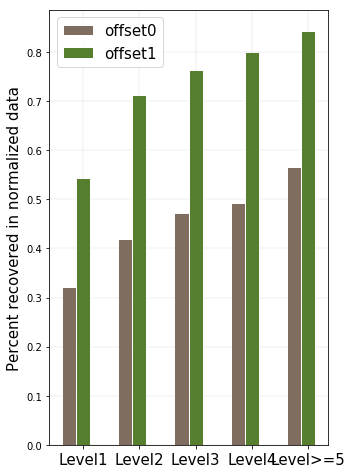

In [10]:
plt.figure(2,figsize=(5,8))
# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = [l1b[1]/float(l1b[0]), l2b[1]/float(l2b[0]), l3b[1]/float(l3b[0]), l4b[1]/float(l4b[0]), l5b[1]/float(l5b[0])]
bars2 = [l1b[2]/float(l1b[0]), l2b[2]/float(l2b[0]), l3b[2]/float(l3b[0]), l4b[2]/float(l4b[0]), l5b[2]/float(l5b[0])]

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='offset0')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='offset1')
 
# Add xticks on the middle of the group bars
plt.ylabel('Percent recovered in normalized data', {'color': 'k', 'fontsize': 15})
plt.xticks([r + barWidth for r in range(len(bars1))], ['Level1', 'Level2', 'Level3', 'Level4', 'Level>=5'], size=15)
 
# Create legend & Show graphic
plt.legend(prop={'size': 15})
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.savefig("/Users/linan/Desktop/raw_norm_boverlap.png", dpi=150, transparent=True)
plt.show()


In [15]:
out = np.array([np.mean(cOnTAD_rawball, axis=0),np.mean(cOnTAD_normball, axis=0)])

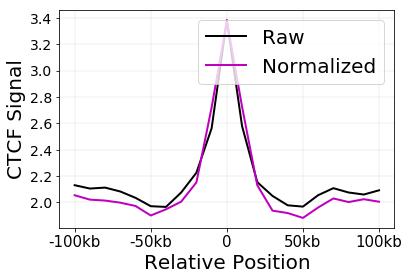

In [16]:
plt.figure(1)
plt.plot(out[0,:],c='k',label='Raw',linewidth=2)
plt.plot(out[1,:],c='m',label='Normalized',linewidth=2)
plt.legend(loc="upper right",prop={'size': 20})
plt.ylabel('CTCF Signal', {'color': 'k', 'fontsize': 20})
plt.xlabel('Relative Position', {'color': 'k', 'fontsize': 20})
plt.yticks(color='k',size=14)
plt.xticks((0,5,10,15,20),('-100kb','-50kb','0','50kb','100kb'),color='k',size=15)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.savefig("/Users/linan/Desktop/raw_norm_ctcf.png", dpi=150, transparent=True)
plt.show()

In [93]:
tt = np.loadtxt('/Users/linan/Downloads/testadjr2allparameter_rawvsnorm_hsz5.txt')

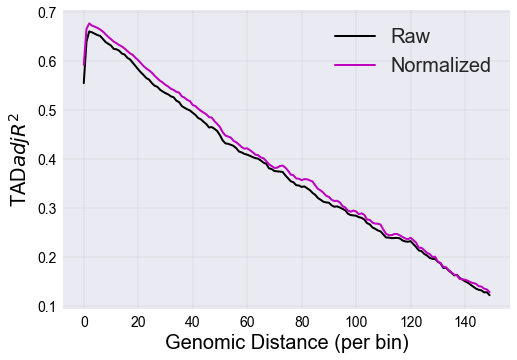

In [120]:
plt.figure(6)
fig,ax = plt.subplots(1)
ax.plot(tt[0,0:150],c='k',label='Raw',linewidth=2)
ax.plot(tt[1,0:150],c='m',label='Normalized',linewidth=2)
plt.legend(loc="upper right",prop={'size': 20} )
plt.ylabel('TAD$adjR^2$', {'color': 'k', 'fontsize': 20})
plt.xlabel('Genomic Distance (per bin)', {'color': 'k', 'fontsize': 20})
plt.yticks(color='k',size=14)
plt.xticks(color='k',size=14)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.savefig("/Users/linan/Desktop/raw_norm_tadrsquared.png", dpi=150, transparent=True)
plt.show()

In [100]:
jartable = pandas.DataFrame({'between reps':jarrep, 'Arrowhead':Arrow_jar, 'offset0':jar0, 'offset1':jar1, 'offset2':jar2})

In [101]:
repint, rnint

(array([  6007.,   1206.,    733.,  10573.,  10939.,  15505.]),
 array([  3593.,   2401.,    800.,   9260.,  10180.,  15847.]))

In [76]:
a = np.array([1,2,4])
b = np.array([1,2,3])
compute_jaccard_index(a,b,0)

0.5

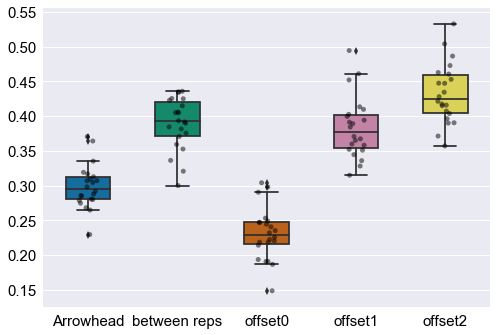

In [102]:
plt.figure(6)
sns.boxplot(data=jartable, width=0.5, palette="colorblind")
sns.stripplot(data=jartable,jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')

plt.yticks(color='k',size=15)
plt.xticks(color='k',size=15)
plt.show()

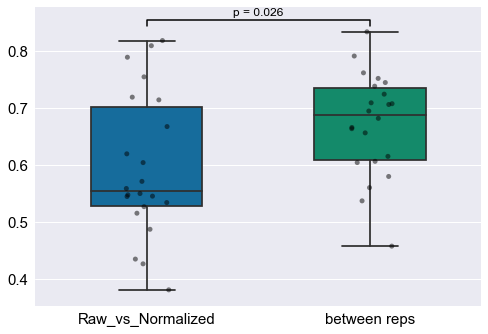

In [121]:
randtable = pandas.DataFrame({'between reps':randrep, 'Raw_vs_Normalized':rand})
sns.boxplot(data=randtable, width=0.5, palette="colorblind")
sns.stripplot(data=randtable,jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')
x1, x2 = 0, 1   # columns 
y, h, col = randtable['between reps'].max() + 0.01, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+1.5*h, r"p = %1.3f"% (stats.ttest_ind(randrep, rand)[1]), ha='center', va='bottom', color=col)
plt.yticks(color='k',size=15)
plt.xticks(color='k',size=15)
plt.show()

In [2]:
(0,0) + (3,4)

(0, 0, 3, 4)